In [301]:
import pandas as pd
import copy
import matplotlib.pyplot as plt

In [302]:
recipes = pd.read_csv("./clean_recipes.csv", delimiter = ";")
reviews = pd.read_csv("./clean_reviews.csv")

In [303]:
#Reduce reviews down to an average
ave_rates = reviews.groupby('RecipeID')['Rate'].mean()
#merge ave reviews with original dataset
prepped_set = recipes.merge(ave_rates, left_on = 'RecipeID', right_on = 'RecipeID')

In [304]:
#Create some potentially useful columns:
#length of instructions
prepped_set['instruction_length'] = prepped_set['Directions'].str.len()
prepped_set['ingredient_count'] = prepped_set['Ingredients'].str.count(",") +1

In [305]:
prepped_set.loc[prepped_set['instruction_length'].isnull(),'instruction_length'] = 0

In [306]:
def clean_ingreds(string):
    ing = ''.join([j for j in filter(lambda y: y.isalpha() | y.isspace(), string)]).strip().lower()
    ing = ing.replace('tablespoons', '')
    ing = ing.replace('tablespoon', '')
    ing = ing.replace('pounds', '')
    ing = ing.replace('pound', '')
    ing = ing.replace('fluid ounces','')
    ing = ing.replace('fluid ounce','')
    ing = ing.replace('fluid oz','')
    ing = ing.replace('ounces','')
    ing = ing.replace('ounce','')
    ing = ing.replace('oz ','')
    ing = ing.replace('cups','')
    ing = ing.replace('cup','')
    ing = ing.replace('to taste','')
    ing = ing.replace('cleaned','')
    ing = ing.replace('whole','')
    ing = ing.replace('packages','')
    ing = ing.replace('package','')
    ing = ing.replace('day old','')
    ing = ing.replace('sheets','')
    ing = ing.replace('grams','')
    ing = ing.replace('gram','')
    ing = ing.replace('inches','')
    ing = ing.replace('inch','')
    ing = ing.replace('bottle','')
    ing = ing.replace('bottled','')
    ing = ing.replace('see note','')
    ing = ing.replace('dash','')
    ing = ing.replace('pinch','')
    ing = ing.replace('es ','')
    ing = ing.strip()
    return ing

In [307]:
ing_list = {}
for i, row in prepped_set['Ingredients'].iteritems():
    row_vals = row.split(',')
    for x in row_vals:
        ing = clean_ingreds(x)
        if ing in ing_list:
            ing_list[ing] += 1
        else:
            ing_list[ing] = 1
            
    
ingreds = pd.DataFrame.from_dict(ing_list, orient='index', columns=['count']).sort_values(by=['count'])
ingreds.to_csv("./ingreds.csv")


In [308]:
#If count greater/equal to 11 (corresponding to top 250ish), use one-hot encoding
#first add appropriate columns to df
delete_list = list()

for x in ing_list:
    if ing_list[x] > 10:
        prepped_set['has_' + x] = 0
    else:
        delete_list.append(x)
        
for key in delete_list: del ing_list[key] 

#Next, parse ingredients accordingly
for i, row in prepped_set['Ingredients'].iteritems():
    row_vals = row.split(',')
    #print(row_vals)
    for x in row_vals:
        ing = clean_ingreds(x)
        if ing in ing_list:
            prepped_set.at[i, 'has_' + ing] = 1

In [309]:
means = prepped_set.mean()

In [310]:
def parse_time(string):
    row_vals = string.split(' ')
    time = -100000
    if (len(row_vals)==1):
        if row_vals[0] == "X":
            return 0
        else:
            return time
    else:
        if row_vals[1] == 'h':
            time = 60 * int(row_vals[0])
        if row_vals[1] == 'm':
            time = int(row_vals[0])
        if row_vals[1] == 'd':
            time = 1440 * int(row_vals[0])
        if len(row_vals) > 2:
            if row_vals[3] == 'm':
                time += int(row_vals[2])
            if row_vals[3] == 'h':
                time += 60 * int(row_vals[2])
            if len(row_vals) > 4:
                if row_vals[5] == 'm':
                    time += int(row_vals[2])
                
        return time
    

In [311]:
#Parse the two time variables

prepped_set['Prep_time_parsed'] = -10000

for i, row in prepped_set['Prepare Time'].iteritems():
    prepped_set.at[i, 'Prep_time_parsed'] = parse_time(row)
        
        
print(prepped_set['Prep_time_parsed'].describe())

count    6426.000000
mean       13.048242
std        20.940639
min         0.000000
25%         0.000000
50%        10.000000
75%        20.000000
max       540.000000
Name: Prep_time_parsed, dtype: float64


In [312]:
prepped_set['Cook_time_parsed'] = -10000

for i, row in prepped_set['Cook Time'].iteritems():
    prepped_set.at[i, 'Cook_time_parsed'] = parse_time(row)
print(prepped_set['Cook_time_parsed'].describe())

count    6426.000000
mean       32.297697
std        76.672352
min         0.000000
25%         0.000000
50%        12.000000
75%        35.000000
max      1440.000000
Name: Cook_time_parsed, dtype: float64


In [313]:
prepped_set['Total_time_parsed'] = -10000

for i, row in prepped_set['Total Time'].iteritems():
    prepped_set.at[i, 'Total_time_parsed'] = parse_time(row)
print(prepped_set['Total_time_parsed'].describe())

count     6426.000000
mean        99.901961
std        763.246895
min          0.000000
25%          0.000000
50%         35.000000
75%         75.000000
max      43320.000000
Name: Total_time_parsed, dtype: float64


In [314]:
#Fix Review count
prepped_set['Review_Count_Num'] = - 1000

for i, row in prepped_set['Review Count'].iteritems():
    if 'k' in row:
        prepped_set.at[i, 'Review_Count_Num'] = int(row.replace('k', '000'))
    else:
        prepped_set.at[i, 'Review_Count_Num'] = int(row)
        

In [315]:
true_rates = prepped_set['Rate']
prepped_set = prepped_set.drop(columns=['Recipe Name', 'Recipe Photo', 'Author', 'Prepare Time', 'Cook Time', 'Total Time', 'Rate', 'Ingredients', 'Directions', 'Review Count'])


In [316]:
prepped_set['Prep_Perc'] = prepped_set["Prep_time_parsed"]/prepped_set['Total_time_parsed']
prepped_set['Cook_Perc'] = prepped_set["Cook_time_parsed"]/prepped_set['Total_time_parsed']

In [317]:
prepped_set.loc[prepped_set['Prep_Perc'].isnull()] = -1
prepped_set.loc[prepped_set['Cook_Perc'].isnull()] = -1

In [318]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import numpy as np
from sklearn.model_selection import train_test_split

In [319]:
X_train, X_test, y_train, y_test = train_test_split(prepped_set, true_rates, test_size=0.3, random_state=42)

In [320]:
clf = RandomForestRegressor(n_estimators=1000, random_state=0)
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [330]:
clf.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [334]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'bootstrap': [True, False], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_leaf': [1, 2, 4], 'max_features': ['auto', 'sqrt'], 'min_samples_split': [2, 5, 10]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 51.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 101.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'bootstrap': [True, False], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_leaf': [1, 2, 4], 'max_features': ['auto', 'sqrt'], 'min_samples_split': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [321]:
print(clf.feature_importances_)

[6.60908056e-02 7.08469607e-02 4.60504734e-02 9.62511597e-04
 1.68817523e-03 1.63008211e-03 5.04937374e-03 7.51138576e-05
 2.30847395e-04 2.00848864e-05 8.17812464e-03 5.66834497e-04
 5.11162206e-04 5.97449691e-03 7.06032745e-04 7.46654308e-04
 6.94289856e-03 1.42806543e-03 4.07861582e-04 9.61766220e-04
 9.05927181e-04 4.77121488e-05 2.38296376e-04 1.35474570e-03
 7.78206611e-05 5.78903829e-04 1.65953770e-04 1.15690319e-03
 1.69093819e-04 1.52052226e-03 9.44949969e-04 8.17854941e-04
 2.81778870e-04 2.04544545e-03 6.59502081e-04 2.68337098e-03
 6.18025972e-05 5.88925771e-05 7.19733589e-04 2.35539612e-04
 6.88706914e-04 1.75961002e-03 7.47811886e-03 1.56321246e-04
 2.51803482e-03 3.70737490e-03 5.21324768e-04 1.62451672e-03
 6.85333871e-05 8.90380960e-04 4.40919544e-04 4.66364129e-03
 6.34080985e-04 5.93463089e-04 8.70979718e-04 1.58668121e-03
 3.11651786e-03 4.18857803e-03 1.08757116e-02 2.45170897e-04
 1.56184080e-03 6.27108635e-05 2.34371534e-04 8.90179020e-03
 1.37552515e-03 2.639533

In [336]:
rf_random.best_params_
best_random = rf_random.best_estimator_
best_predictions = best_random.predict(X_test)
best_rms = sqrt(mean_squared_error(y_test, best_predictions))
best_rms


0.29073384420110204

In [322]:
predictions = clf.predict(X_test)
len(predictions)

1928

In [323]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, predictions))
rms

0.29343019246736063

In [324]:
pd.Series(predictions).describe()

count    1928.000000
mean        4.407906
std         0.121567
min         3.554617
25%         4.354184
50%         4.367849
75%         4.496710
max         4.748194
dtype: float64

In [325]:
y_test.describe()

count    1928.000000
mean        4.407659
std         0.316342
min         1.800000
25%         4.266667
50%         4.466667
75%         4.620690
max         4.933333
Name: Rate, dtype: float64

In [326]:
pd.concat([y_test.reset_index(), pd.Series(predictions)], axis = 1).corr()


,index,Rate,0
index,1.000000,0.049967,0.169705
Rate,0.049967,1.000000,0.373211
0,0.169705,0.373211,1.000000


Text(0, 0.5, 'true')

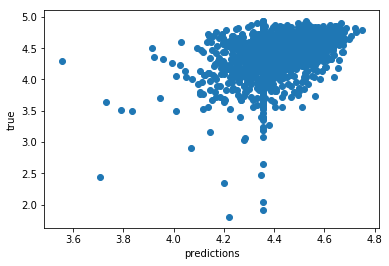

In [327]:
plt.scatter(pd.Series(predictions), y_test)
plt.xlabel('predictions')
plt.ylabel('true')

In [328]:
pd.concat([y_test.reset_index(), pd.Series(predictions)], axis = 1)

,index,Rate,0
0,324,4.453333,4.354184
1,5396,4.714286,4.516629
2,4894,4.233333,4.451766
3,2548,4.551724,4.354184
4,381,4.233333,4.452915
5,3551,4.294118,4.412215
6,4414,4.722222,4.485043
7,4991,4.711111,4.415082
8,1345,3.586207,4.331280
9,1807,4.801230,4.661619
